In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
!git clone https://github.com/Amey-2002/GSoC_2022_QMLHEP

Cloning into 'GSoC_2022_QMLHEP'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 223 (delta 4), reused 8 (delta 3), pack-reused 212
Receiving objects: 100% (223/223), 1.76 MiB | 24.37 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [ ]:
# To remove the cloned repo from the folders section, uncomment the following command

# !rm -rf GSoC_2022_QMLHEP

In [3]:
%cd /content/GSoC_2022_QMLHEP/

/content/GSoC_2022_QMLHEP


In [4]:
from IPython.display import clear_output
!pip install tensorflow-quantum==0.6.0 --use-deprecated=legacy-resolver
clear_output()

### Getting the imports

In [5]:
import numpy as np
import tensorflow as tf
from h5py import File as HDF5File
import QGANSHEP
from QGANSHEP.Quantum_Conv2D_layer import QConv2D_layer
from QGANSHEP import QGANS, preprocess_utils, frechet_inception_distance, visualizations
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
electron_datafile = '/content/gdrive/MyDrive//electron.hdf5'
photon_datafile = '/content/gdrive/MyDrive//photon.hdf5'

In [ ]:
electron_data = HDF5File(electron_datafile, 'r')
photon_data = HDF5File(photon_datafile, 'r')

In [ ]:
electron_data.keys()

<KeysViewHDF5 ['X', 'y']>

In [ ]:
X_electron = electron_data['X']

In [ ]:
X_electron.shape

(249000, 32, 32, 2)

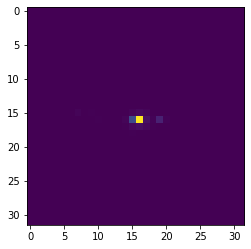

In [ ]:
#Let's have a look on one of the images
plt.imshow(X_electron[0,:,:,0])

In [ ]:
X_electron = electron_data['X'][:,:,:,0]

In [ ]:
X_electron.shape

(249000, 32, 32)

In [ ]:
#preprocess the images(here: crop the images)X_electron = preprocess_utils.crop_images(X_electron,(8,8))
X_electron = X_electron[:300]

In [ ]:
#vanity check
X_electron.shape

(300, 32, 32)

In [ ]:
X_electron = preprocess_utils.crop_images(X_electron,(8,8))

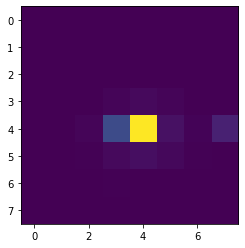

In [ ]:
#Let's have a look at the image after cropping it.
plt.imshow(X_electron[0])

### Generator

In [ ]:
def create_classical_generator():
    model = tf.keras.Sequential()
    # foundation for 2x2 image
    n_nodes = 64 * 2 * 2
    model.add(tf.keras.layers.Dense(n_nodes, use_bias=False, input_shape=(70,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((2, 2, 64)))

    # model.add(tf.keras.layers.Conv2DTranspose(2, (2,2), strides=(1,1), padding="same", use_bias=False))
    # model.add(tf.keras.layers.BatchNormalization())
    # model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(8, (2,2), strides=(1,1), padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # upsample to 4x4
    model.add(tf.keras.layers.Conv2DTranspose(8, (2,2), strides=(2,2), padding="same", use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())    
    # upsample to 8x8
    model.add(tf.keras.layers.Conv2DTranspose(1, (3,3), strides=(2,2), padding="same", use_bias=False))   #, activation='tanh'
    return model

In [ ]:
generator_model = create_classical_generator()

###Discriminator

In [ ]:
def create_quantum_discriminator():
  model = tf.keras.Sequential(name = 'Discriminator_Improved')
  model.add(tf.keras.Input(shape=(8, 8, 1),dtype=tf.dtypes.float32,name='Input_layer'))
  # model.add(tf.keras.layers.Reshape((8, 8, 1)))
  # model.add(QConv2D_layer(circuit_layers=2, filter_shape=(4, 4),conv_id = '1',
  #                     filters=1, stride=(1, 1), padding="same", parameter_sharing=False,seed=2022,
  #                     )) 
  model.add(QConv2D_layer(circuit_layers=3, filter_shape=(3, 3),conv_id ='2',
                      filters=2, stride=(2, 2), padding="same", parameter_sharing=False,seed=2021,
                      ))
  model.add(QConv2D_layer(circuit_layers=2, filter_shape=(2, 2),conv_id = '3',
                      filters=1, stride=(2, 2), padding="same", parameter_sharing=False,seed=2022,
                      )) 
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))
  return model

In [ ]:
discriminator_model = create_quantum_discriminator()

In [ ]:
generator_model.summary()
discriminator_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               17920     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 2, 2, 8)          2048      
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 2, 2, 8)          3

###QGAN Model

In [ ]:
# setting the optimizer for the generator and discriminator along with the learning rate 
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# initiating the model
model = QGANS.QGAN(generator=generator_model,discriminator=discriminator_model,disc_optimizer=d_optimizer,gen_optimizer=g_optimizer)

In [ ]:
X_electron_final = np.reshape(X_electron, (X_electron.shape[0], 8, 8, 1))
gen_loss, disc_loss ,epochs = model.train_qgans(X_electron,epochs=20,batch_size=70,seed=2021,n_gen=5)

Epoch:0 ;   generator_loss:-0.6599339842796326 ;   discriminator_loss:1.418966293334961
Epoch:1 ;   generator_loss:-0.686418354511261 ;   discriminator_loss:1.426222324371338
Epoch:2 ;   generator_loss:-0.7020759582519531 ;   discriminator_loss:1.4275482892990112
Epoch:3 ;   generator_loss:-0.7121318578720093 ;   discriminator_loss:1.4270179271697998
Epoch:4 ;   generator_loss:-0.7160586714744568 ;   discriminator_loss:1.4235761165618896
Epoch:5 ;   generator_loss:-0.7174001932144165 ;   discriminator_loss:1.420361042022705
Epoch:6 ;   generator_loss:-0.7175227403640747 ;   discriminator_loss:1.4181182384490967
Epoch:7 ;   generator_loss:-0.7141509056091309 ;   discriminator_loss:1.414242148399353
Epoch:8 ;   generator_loss:-0.7096615433692932 ;   discriminator_loss:1.4103279113769531
Epoch:9 ;   generator_loss:-0.7051548957824707 ;   discriminator_loss:1.4065312147140503
Epoch:10 ;   generator_loss:-0.7011843919754028 ;   discriminator_loss:1.4029011726379395
Epoch:11 ;   generator_lo

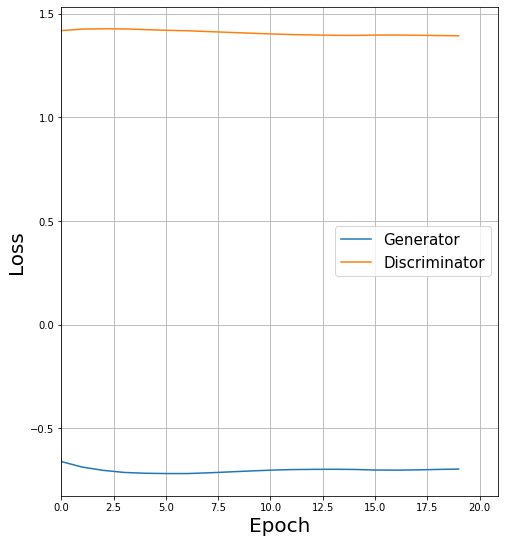

In [ ]:
model.plot_loss(gen_loss,disc_loss,epochs)

Generating random data...
Fetching images from generator...
Generated Images:


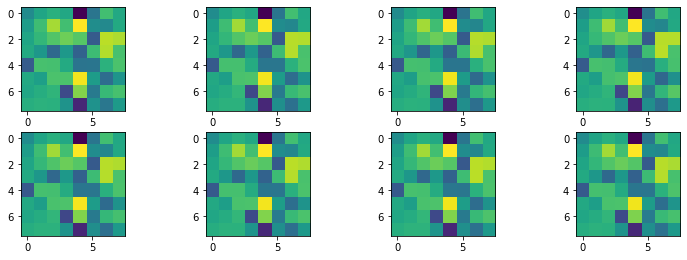

In [ ]:
samples = model.create_images(batch_size=100)

In [ ]:
fid = frechet_inception_distance.FID()
print(f'Frechet Inception Distance for the generated images is: {fid.calculate(X_electron[:100],samples)}')

87924736/87910968 [==============================] - 2s 0us/step
Frechet Inception Distance for the generated images is: 336.66514513612015
